In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, add, Cropping2D, ReLU, BatchNormalization, Lambda, PReLU
from tensorflow.keras.layers import Concatenate, Reshape, MaxPooling1D, Cropping1D, ZeroPadding1D, Flatten
from tensorflow.keras.layers import AveragePooling2D, LSTM, RepeatVector, TimeDistributed, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras.backend import expand_dims

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

In [2]:
height_x = 120
width_x = 120
channels = 3
shape_x = (height_x, width_x, channels)
width_y = 27
shape_y = (height_x, width_y, channels)

data_num = 2
data_dir = f"../../datasets/dataset_0{data_num}/quarter/"
name = "resnet-120x120"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25

batch_size = 32
epochs = 50
learning_rate = 1e-4

workers = 6

In [3]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                    flip = random.randint(0, 1)
                    if flip:
                        image = np.flip(image, axis=1)
                    crop = random.randint(0, 13)
                    image = image[:,crop:,:]
                    image_x = image[:,:120,:]
                    image_y = image[:,120:147,:]
                    Y.append(image_y)
                    X.append(image_x)
                    #print(f'X: {image_x.shape} | Y: {image_y.shape}\nCrop: {crop} | Image: {image.shape}')
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        return X, Y

In [4]:
def block(input, kernels):
    x = Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x_0 = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x_0 = BatchNormalization()(x_0)

    x = add([x,x_0])
    x = ReLU()(x)
    return x

input_x = Input(shape=shape_x)
x = Lambda(lambda x: x[:,:,-120:,:])(input_x)

x = Conv2D(64, kernel_size=7, strides=(1,1))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
list_x = []
list_x.append(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

for i in range(4):
    list_x.append(x)
    for j in range(3):
        x = block(x, 64 * (2**i))
    x = MaxPooling2D()(x)
list_x.append(x)
padding = 'valid'

x = Conv2DTranspose(1024, kernel_size=3,strides=(2,2), padding=padding)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(1024, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x,list_x[-2]])
x = ReLU()(x)

x = Conv2DTranspose(512, kernel_size=3,strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(512, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x,list_x[-3]])
x = ReLU()(x)
#x = ZeroPadding2D(padding=(1,0))(x)

x = Conv2DTranspose(256, kernel_size=3,strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x,list_x[-4]])
x = ReLU()(x)

x = Cropping2D(cropping=((0,0),(0,1)))(x)

x = Conv2DTranspose(128, kernel_size=3,strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x_1 = Conv2D(128, kernel_size=3, strides=(1,2), padding='same')(list_x[1])
x_1 = Cropping2D(cropping=((0,0),(0,1)))(x_1)
x = add([x,x_1])
x = ReLU()(x)

x = Conv2DTranspose(64, kernel_size=3,strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = ZeroPadding2D(padding=(1,0))(x)
x = Conv2D(64, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x_0 = Conv2D(64, kernel_size=3, strides=(1,4), padding='same')(list_x[0])
x_0 = Cropping2D(cropping=((0,0),(0,2)))(x_0)
x = add([x,x_0])
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=(3,1),strides=(1,1), padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=(3,1),strides=(1,1), padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=(3,1),strides=(1,1), padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

#x = ZeroPadding2D(padding=(3,0))(x)
x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)

#x = Conv2DTranspose(128, kernel_size=3,strides=(2,1), padding=padding)(x)
#x_5 = Conv2DTranspose(64, kernel_size=3,strides=(2,1), padding=padding)(x)
##x = UpSampling2D(size=(4,1))(list_x[2])
#x = AveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(360, activation='relu', activity_regularizer=regularizer)(x)

#x = Reshape((120,3))(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 114, 114, 64) 9472        lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 114, 114, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [5]:
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='mean_absolute_error')

In [219]:
files = os.listdir(data_dir)
gen_loader = DataGenerator(files, batch_size=batch_size)
autoencoder.fit(gen_loader, epochs=epochs, steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/50
1000/1000 [==============================] - 361s 361ms/step - loss: 0.0376
Epoch 2/50
1000/1000 [==============================] - 356s 356ms/step - loss: 0.0374
Epoch 3/50
1000/1000 [==============================] - 367s 367ms/step - loss: 0.0372
Epoch 4/50
1000/1000 [==============================] - 374s 374ms/step - loss: 0.0371
Epoch 5/50
1000/1000 [==============================] - 321s 321ms/step - loss: 0.0370
Epoch 6/50
1000/1000 [==============================] - 329s 329ms/step - loss: 0.0366
Epoch 7/50
1000/1000 [==============================] - 359s 359ms/step - loss: 0.0365
Epoch 8/50
1000/1000 [==============================] - 358s 358ms/step - loss: 0.0368
Epoch 9/50
1000/1000 [==============================] - 358s 358ms/step - loss: 0.0364
Epoch 10/50
1000/1000 [==============================] - 363s 363ms/step - loss: 0.0361
Epoch 11/50
1000/1000 [==============================] - 367s 367ms/step - loss: 0.0360
Epoch 12/50
1000/1000 [==================

### Epoches saved: 250 L2 + 50 L1

In [220]:
#autoencoder.save_weights('saved_models/'+name+'-l1')

In [6]:
autoencoder.load_weights('saved_models/'+name+'-l1')

### Epoches saved: 250 L2

In [ ]:
#autoencoder.save_weights('saved_models/'+name+)

In [6]:
#autoencoder.load_weights('saved_models/'+name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


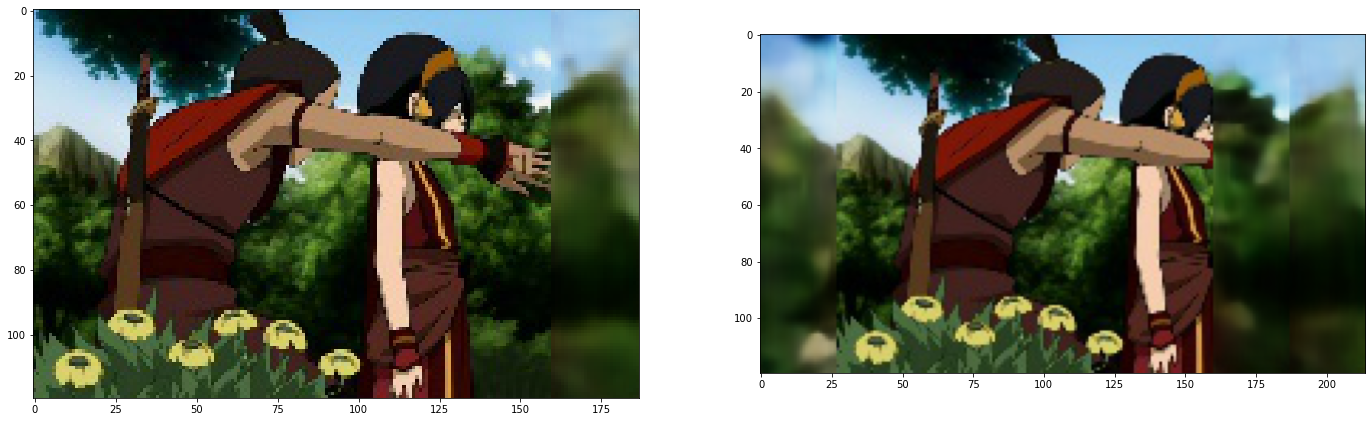

In [83]:
random_names = os.listdir(data_dir)
image_name = random_names[random.randint(0, len(random_names))]
image_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir, image_name)), dtype=float)
image = image_true[:,:133,:]

for i in range(2):
    image_x = image[:,-120:,:]
    image_y_pred = autoencoder(np.expand_dims(image_x,axis=0))
    image = np.concatenate((image, image_y_pred[0]), axis=1)

image_x_flip = np.flip(image[:,:120,:], axis=1)
image_y_pred_flip = autoencoder(np.expand_dims(image_x_flip,axis=0))
image_y_pred_flip = np.flip(image_y_pred_flip[0], axis=1)
image = np.concatenate((image_y_pred_flip, image), axis=1)

image_right = autoencoder(np.expand_dims(image_true[:,-120:,:],axis=0))
image_true = np.concatenate((image_true, image_right[0]), axis=1)
image_true = np.concatenate((image_y_pred_flip, image_true), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image)